Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)
Number of classes: 10


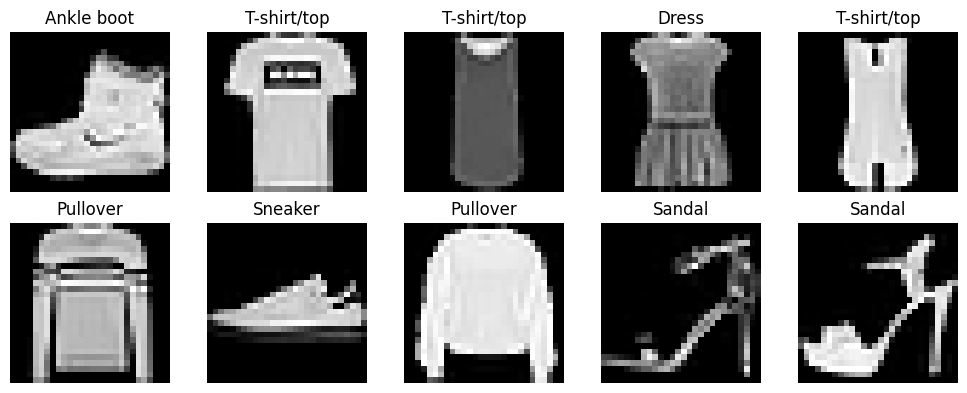

Epoch 0 - Loss: 0.6131, Accuracy: 0.8377
Epoch 2 - Loss: 0.6933, Accuracy: 0.8680
Epoch 4 - Loss: 0.6286, Accuracy: 0.8685
Epoch 6 - Loss: 0.2769, Accuracy: 0.8941
Epoch 8 - Loss: 0.4006, Accuracy: 0.8932
Epoch 10 - Loss: 0.3159, Accuracy: 0.8981
Epoch 12 - Loss: 0.3019, Accuracy: 0.9084
Epoch 14 - Loss: 0.2512, Accuracy: 0.9133
Epoch 16 - Loss: 0.2137, Accuracy: 0.9129
Epoch 18 - Loss: 0.1785, Accuracy: 0.9208
Epoch 19 - Loss: 0.2758, Accuracy: 0.9220
Test Accuracy: 0.8840


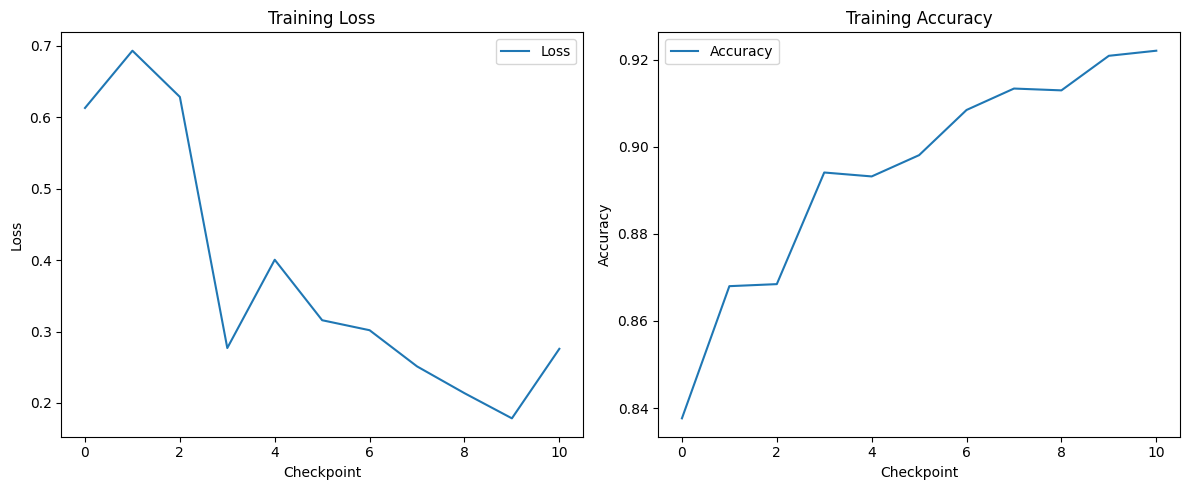

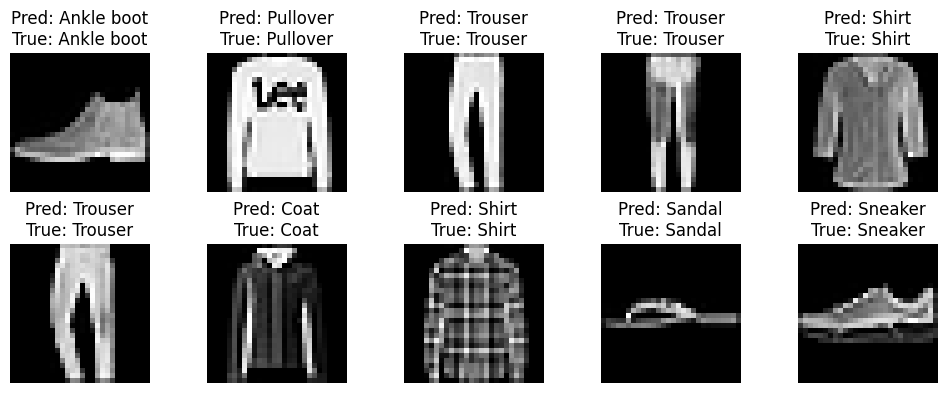

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load and inspect the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Number of classes:", len(np.unique(train_labels)))

# Class labels
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Show example images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap="gray")
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Preprocessing
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_onehot = one_hot_encode(train_labels)
test_labels_onehot = one_hot_encode(test_labels)

# Activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# Loss function
def cross_entropy(true_labels, predicted_probs):
    m = true_labels.shape[0]
    return -np.sum(true_labels * np.log(predicted_probs + 1e-8)) / m

# Weight initialization
def initialize_parameters(input_size, hidden_size, output_size):
    hidden_weights = np.random.randn(input_size, hidden_size) * np.sqrt(2. / (input_size + hidden_size))
    hidden_bias = np.zeros((1, hidden_size))
    output_weights = np.random.randn(hidden_size, output_size) * np.sqrt(2. / (hidden_size + output_size))
    output_bias = np.zeros((1, output_size))
    return hidden_weights, hidden_bias, output_weights, output_bias

# Forward pass
def forward_pass(inputs, hidden_weights, hidden_bias, output_weights, output_bias):
    hidden_layer_input = np.dot(inputs, hidden_weights) + hidden_bias
    hidden_layer_output = relu(hidden_layer_input)
    output_layer_input = np.dot(hidden_layer_output, output_weights) + output_bias
    output_probs = softmax(output_layer_input)
    return hidden_layer_input, hidden_layer_output, output_layer_input, output_probs

# Backward pass
def backward_pass(inputs, true_labels, hidden_layer_input, hidden_layer_output, output_probs, output_weights):
    m = inputs.shape[0]
    error_output = output_probs - true_labels
    gradient_output_weights = np.dot(hidden_layer_output.T, error_output) / m
    gradient_output_bias = np.sum(error_output, axis=0, keepdims=True) / m

    error_hidden = np.dot(error_output, output_weights.T)
    gradient_hidden_input = error_hidden * relu_derivative(hidden_layer_input)
    gradient_hidden_weights = np.dot(inputs.T, gradient_hidden_input) / m
    gradient_hidden_bias = np.sum(gradient_hidden_input, axis=0, keepdims=True) / m

    return gradient_hidden_weights, gradient_hidden_bias, gradient_output_weights, gradient_output_bias

# Training function
def train_model(inputs, labels, hidden_size=128, learning_rate=0.01, epochs=100, batch_size=64):
    input_size = inputs.shape[1]
    output_size = labels.shape[1]
    hidden_weights, hidden_bias, output_weights, output_bias = initialize_parameters(input_size, hidden_size, output_size)

    losses = []
    accuracies = []

    for epoch in range(epochs):
        shuffled_indices = np.random.permutation(inputs.shape[0])
        inputs, labels = inputs[shuffled_indices], labels[shuffled_indices]

        for start in range(0, inputs.shape[0], batch_size):
            end = start + batch_size
            batch_inputs = inputs[start:end]
            batch_labels = labels[start:end]

            hidden_input, hidden_output, output_input, output_probs = forward_pass(
                batch_inputs, hidden_weights, hidden_bias, output_weights, output_bias
            )

            loss = cross_entropy(batch_labels, output_probs)

            grad_hidden_weights, grad_hidden_bias, grad_output_weights, grad_output_bias = backward_pass(
                batch_inputs, batch_labels, hidden_input, hidden_output, output_probs, output_weights
            )

            # Update parameters
            hidden_weights -= learning_rate * grad_hidden_weights
            hidden_bias -= learning_rate * grad_hidden_bias
            output_weights -= learning_rate * grad_output_weights
            output_bias -= learning_rate * grad_output_bias

        # Evaluate training performance occasionally
        if epoch % 2 == 0 or epoch == epochs - 1:
            _, _, _, train_probs = forward_pass(inputs, hidden_weights, hidden_bias, output_weights, output_bias)
            predictions = np.argmax(train_probs, axis=1)
            accuracy = np.mean(predictions == np.argmax(labels, axis=1))
            print(f"Epoch {epoch} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
            losses.append(loss)
            accuracies.append(accuracy)

    return hidden_weights, hidden_bias, output_weights, output_bias, losses, accuracies

# Evaluation function
def evaluate_model(inputs, labels, hidden_weights, hidden_bias, output_weights, output_bias):
    _, _, _, output_probs = forward_pass(inputs, hidden_weights, hidden_bias, output_weights, output_bias)
    predicted_labels = np.argmax(output_probs, axis=1)
    accuracy = np.mean(predicted_labels == np.argmax(labels, axis=1))
    return accuracy, predicted_labels

# Train 
hidden_weights, hidden_bias, output_weights, output_bias, training_losses, training_accuracies = train_model(
    train_images, train_labels_onehot, learning_rate=0.1, epochs=20
)

# I adjusted the learning rate and epoch and found 0.1 and roughly 20 epochs to give satisfactory accuracy in 
# my testing. Anything slower causes instability in loss and fewer epochs gave less accuracy.

# Test 
test_accuracy, test_predictions = evaluate_model(
    test_images, test_labels_onehot, hidden_weights, hidden_bias, output_weights, output_bias
)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Loss')
plt.title("Training Loss")
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Checkpoint")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {class_names[test_predictions[i]]}\nTrue: {class_names[test_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
